# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by an other algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some ways to compare two given distributions $p_D$ and $p_\theta$?**


>How can we compare two distributions
statistical test? 
We need distances that can be differianted and to be able to compute some graedients through these distances.
Two big families of comparisons: 

> $KL(p||q) = E_plog(\frac{p(x)}{q(x)})$ : The Kullback–Leibler Divergence 

>$MMD(p||q) = E[||K(x)-K(Y)||]$ : The Maximum Mean Discrepancy

>We can also mention the Kolmogorov-Smirnof Test



Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them directly.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> **Methods that compare the density of the distributions** : We must know the density functions (or a good approximation) of the 2 distributions.
>
> **Methods that compare the sampled values** : We must have enough representative values from the 2 distributions.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strenghts and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimentional gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

> We need the input noise to be large enough to be able to capture the high-dimensional target space structure with a function that can be learned by a neural network
On the other hand we don't want $\epsilon$ to be too high-dimensional to be able to train the network and interpret it.

By construction, this generator structure only allows sampling of the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$. Such a model seems to need a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to differentiate examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator (whose output is denoted by $D(x)$) is trained using a classic discrimination loss, so that $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the JSD between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> An issue with that training objective is that it has some 'flat' areas when the discriminator is too good or not good enough. 

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what can this imply?**

> The generator is only learning through feedback, he has no connexion to real data. Therefore if it manages to capture one aspect of the correct data, it can simply rely on this knowledge. This is called **mode collapse**. In that cas it has not succeeded in generating the correct distribution but just part of this distribution. 

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be 25 Gaussian distributions with small variance, distributed on a $5\times 5$ grid.

In [2]:
import torch

from IPython.display import display, HTML  
from pprint import pprint
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the 25-gaussian dataset.
    
    return a torch tensor of dimensions (batchlen, 2)
    """
    # to sample from the gaussian mixture, we first sample the means for each point, then
    # add a gaussian noise with small variance
    samples = torch.multinomial(torch.tensor([0.2,0.2,0.2,0.2,0.2]), 2*batchlen, replacement=True)
    means = (2.0 * (samples - 2.0)).view(batchlen,2).type(torch.FloatTensor)
    return torch.normal(means, 0.05)

Let's plot a batch, to see what the dataset looks like.

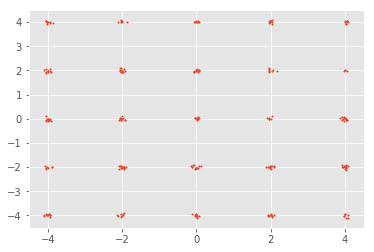

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(256)

plt.scatter(batch[:,0], batch[:,1], s=2.0, label='Batch of data from our gaussian mixture dataset')
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

When representing a binary classifier with a neural network, it is better for the last layer to consist of only a sigmoid activation, so that the output values will be between 0 and 1 and stand for the probability (according to the classifier) that the input is of the first class. The output is thus of the form $\mathrm{sigmoid}(h)$. The loss involves quantities such as $-\log(\mathrm{sigmoid}(h))$. For numerical stability reasons, it is recommended to rewrite the loss in order to make use of the $\mathrm{softplus}$ function defined by $\mathrm{softplus}(h) = \log(1 + \exp(h))$ and provided in PyTorch as `torch.softplus`.
As the $\mathrm{softplus}(h)$ formulation of the loss already contains the sigmoid activation, in practice the last layer of the discrimator network will not have any activation function (being just $h$).

In [4]:

import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N =20

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
        #self.fc5 = nn.Linear(16, 2)


    def __call__(self, z):
        d0 = F.dropout(z,0.3)
        h1 = F.leaky_relu(self.fc1(d0))
        d1 = F.dropout(h1,0.1)
        h2 = F.leaky_relu(self.fc2(d1))
        d2 = F.dropout(h2,0.1)
        h3 = F.leaky_relu(self.fc3(d2))
        d3 = F.dropout(h3,0.3)
        #h4 = F.relu(self.fc4(h3))

        return self.fc4(d3)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 200.0,generator=torch.manual_seed(14))
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,2)
    
    def __call__(self, x):
        h1 = F.leaky_relu(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        d3 = F.dropout(h3,0.1)
        return self.fc4(d3)

With these classes in shape, only the training loop is still missing. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, its gradient will vanish (as seen in **Q4**) and thus no information will be passed to the generator.

We will then train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 6.914e-01, generator: 8.005e-01


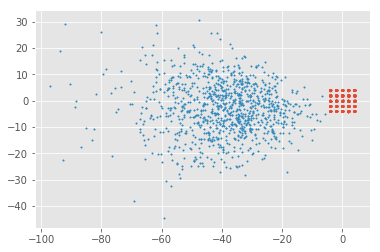

step 100: discriminator: 8.740e-01, generator: 8.170e-01


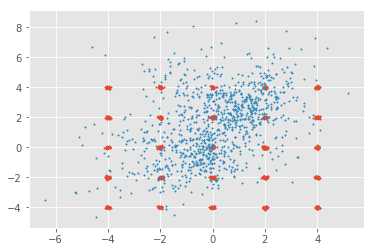

step 200: discriminator: 1.017e+00, generator: 4.918e-01


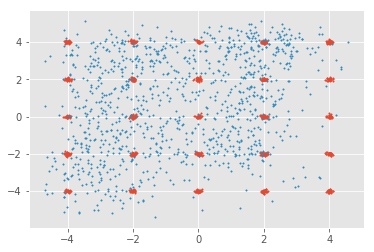

step 300: discriminator: 7.436e-01, generator: 7.606e-01


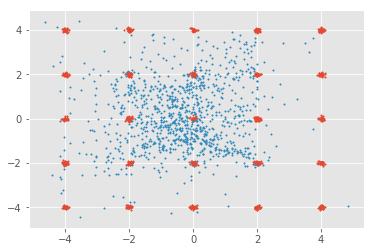

step 400: discriminator: 5.671e-01, generator: 9.055e-01


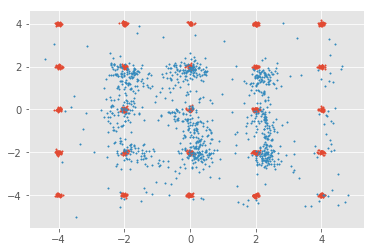

step 500: discriminator: 6.216e-01, generator: 9.114e-01


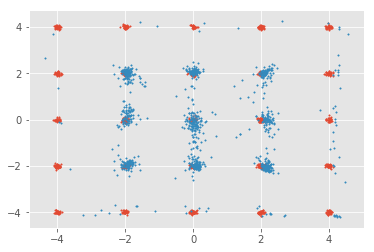

step 600: discriminator: 5.809e-01, generator: 9.452e-01


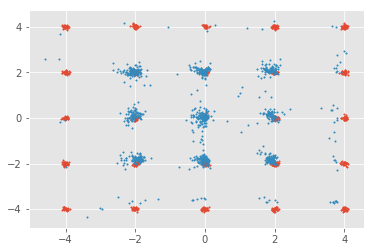

step 700: discriminator: 5.322e-01, generator: 9.705e-01


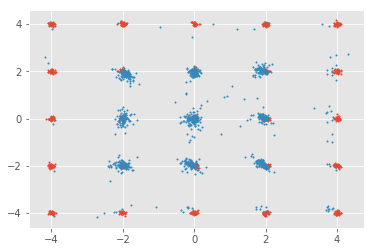

step 800: discriminator: 6.097e-01, generator: 9.235e-01


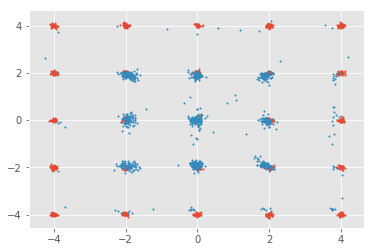

step 900: discriminator: 5.135e-01, generator: 1.132e+00


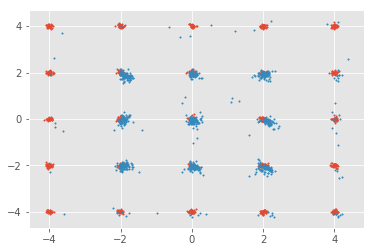

step 1000: discriminator: 5.468e-01, generator: 1.079e+00


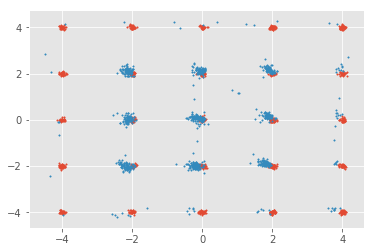

step 2000: discriminator: 3.628e-01, generator: 1.606e+00


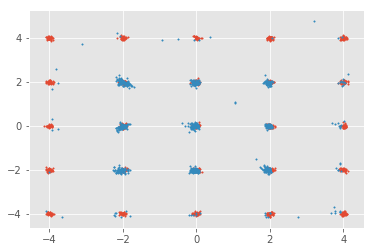

step 3000: discriminator: 5.081e-01, generator: 1.094e+00


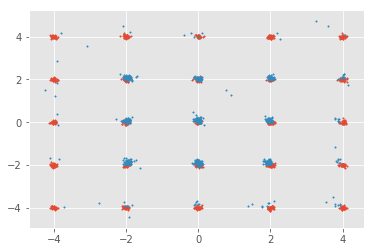

step 4000: discriminator: 5.406e-01, generator: 8.987e-01


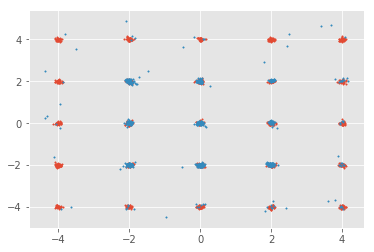

step 5000: discriminator: 3.318e-01, generator: 2.134e+00


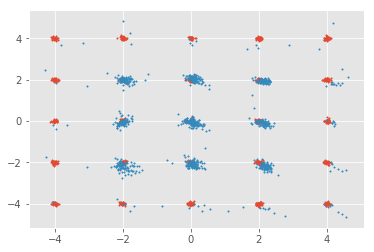

step 6000: discriminator: 3.706e-01, generator: 1.778e+00


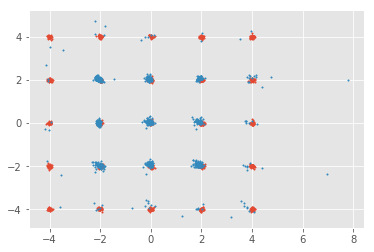

step 7000: discriminator: 4.851e-01, generator: 9.777e-01


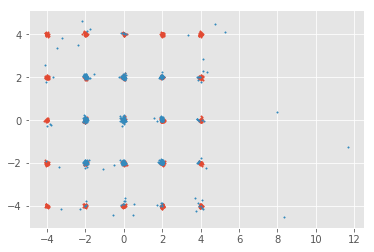

step 8000: discriminator: 5.019e-01, generator: 9.945e-01


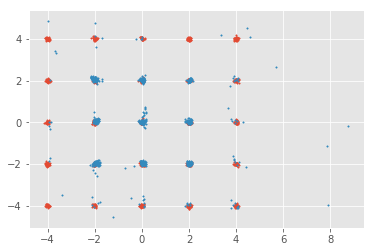

step 9000: discriminator: 4.064e-01, generator: 1.732e+00


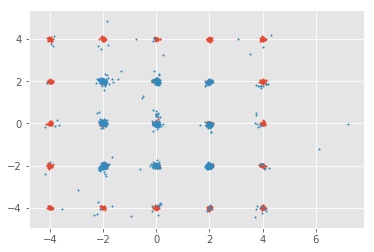

step 10000: discriminator: 4.667e-01, generator: 9.457e-01


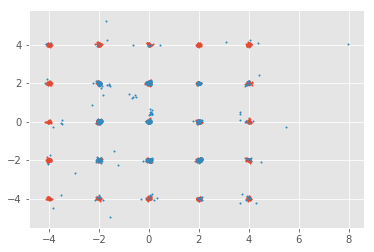

step 11000: discriminator: 4.516e-01, generator: 1.133e+00


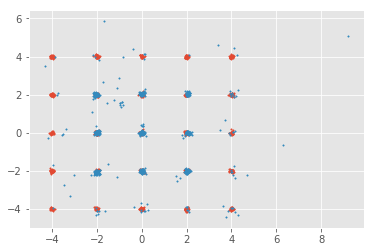

step 12000: discriminator: 4.686e-01, generator: 9.004e-01


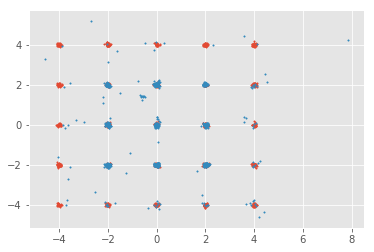

step 13000: discriminator: 3.454e-01, generator: 2.262e+00


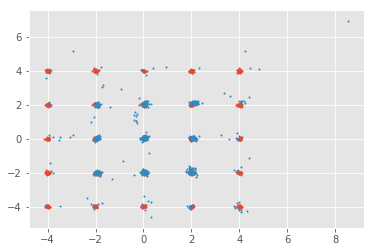

step 14000: discriminator: 4.562e-01, generator: 9.643e-01


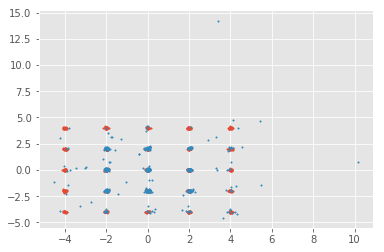

step 15000: discriminator: 4.458e-01, generator: 9.063e-01


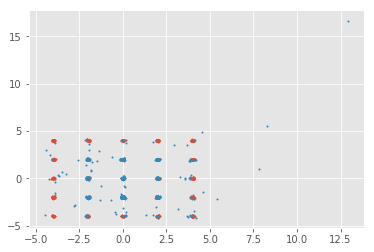

step 16000: discriminator: 2.402e-01, generator: 4.160e+00


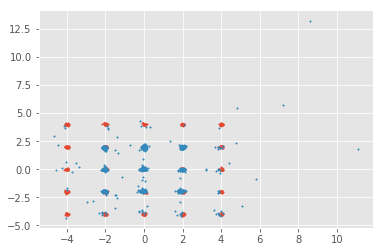

step 17000: discriminator: 4.199e-01, generator: 1.189e+00


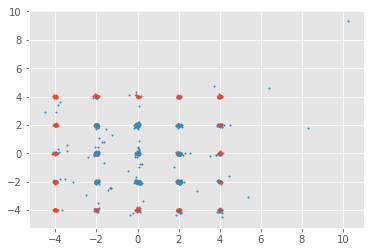

step 18000: discriminator: 4.512e-01, generator: 8.916e-01


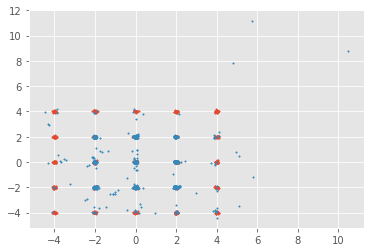

step 19000: discriminator: 4.401e-01, generator: 9.119e-01


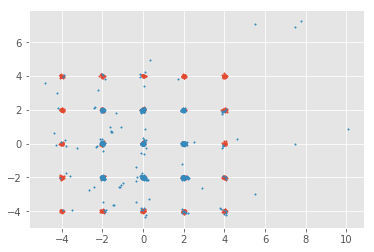

step 20000: discriminator: 3.701e-01, generator: 1.524e+00


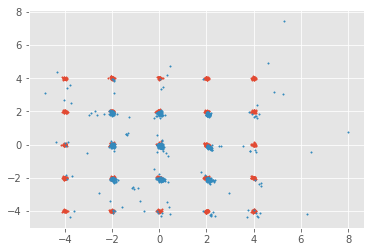

In [8]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 3
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 1024

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
        # torch.softplus, using real_batch and fake_batch
        
        #Separation of the loss in two backpropagation according to some litteratures it can help convergence
        disc_loss = torch.mean(F.softplus(-discriminator(real_batch))) # FILL HERE
        disc_loss.backward()
        optim_disc.step()
        
        disc_loss = torch.mean(F.softplus(discriminator(fake_batch))) 
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    # Compute here the generator loss, using fake_batch
    gen_loss = torch.mean(F.softplus(-discriminator(fake_batch)))
    gen_loss.backward()
    optim_gen.step()
    if i<1000 :
        if (i%100 == 0):
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.show()
    else : 
        if (i%1000 == 0):
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> When the discriminator gets closer to optimum the gradient vanishes leading to an absence in corrections for the generator : 
$ lim_{D \rightarrow optimal} \Delta_{\theta} \mathcal{L}_G = 0$

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> *- depth / width of the generator network*  
Too small = The model does not learn anything and won't converge. 
Too big = The training takes too long and the network needs more time, updates and data to converge.
In the litterature it is considered insightful to have a deep architecture for the discriminator and a lighter one for the generator : 
"The model for the discriminator is usually more complex than the generator (more filters and more layers) and a good discriminator gives quality information. In many GAN applications, we may run into bottlenecks where increasing generator capacity shows no quality improvement. Until we identify the bottlenecks and resolve them, increasing generator capacity does not seem to be a priority"

> *- depth / width of the discriminator network*  
It seems logical that this network has to be more advanced, this can be achieved through depth and width but also through additional training iterations, as we are doing in this example. 
Nevertheless our architecture taking as inputs simple distributions, it could be seen as normal to reach convergence with an architecture that shows slightly more width and depth for the generator. 


> *- impact of `TRAIN_RATIO`*  
The train ratio is a trade-off between the improvement of the Discriminator in order to get good feedbacks to the generator and vanishing gradient problems. When the Discriminator is too good, the feedbacks it gives do not let any room for improvement for the generator.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

An other well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

> $D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D} \left[\log \frac{p_D(x)}{p_\theta(x)}\right] = \mathbb{E}_{p_D} \left[\log p_D(x)\right] - \mathbb{E}_{p_D} \left[\log p_\theta(x)\right] $
> 
> $\mathbb{E}_{p_D} \left[\log p_D(x)\right]$ does not depend on $\theta$, so minimizing $D_{KL}(p_D \| p_\theta) $ with respect to $\theta$ is equivalent to minimizing $- \mathbb{E}_{p_D} \left[\log p_\theta(x)\right] $ which is equivalent to maximizing $\mathbb{E}_{p_D} \left[\log p_\theta(x)\right] $

However, the class of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution like so: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Where here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)ds$ is an infinite mixture of gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce an other, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> The model only have to learn what differe from, for instance, one face to another, but if the data samples are very different, the model will have very hard time to learn as it doesn't have feedback on previously generated data. This lead to an overfitting.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> With $p_1 \sim \mathcal{N_0}(\mu_0; \Sigma_0)$ and $p_2 \sim \mathcal{N_1}(\mu_1; \Sigma_1)$ 
>
> $D_{KL}(p_1||p_2) = \frac{1}{2}(tr(\Sigma_2^{-1}\Sigma_1)+(\mu_2-\mu_1)^{T}\Sigma_2^{-1}(\mu_2-\mu_1)-N+log(\frac{|\Sigma_2|}{|\Sigma_1|}) $
>  
> In our case we have : 
>  * $\mu_2 = 0$ , $\mu_1 = \mu_\phi(x)$
>  * $\Sigma_2 = I_d$ , $\Sigma_1 = Diag(\sigma_\phi(x))$
> 
> Injecting them we get :
> $D_{KL}(p_1||p_2) = \frac{1}{2}\left(tr(Diag(\sigma_\phi(x)))+\mu_\phi(x)^{T}\mu_\phi(x)-N+log\left(\frac{1}{|Diag(\sigma_\phi(x))|}\right)\right)$
> 
> By definition we also have :
> * $\displaystyle  |Diag(\sigma_\phi(x))| = \prod_{i}\sigma_{\phi(x_i)})$
> * $\displaystyle tr(Diag(\sigma_\phi(x)) = \sum_{i} \sigma_\phi(x_i)$
>
>And finally we get :
>  $\displaystyle D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \sum_{i} \sigma_\phi(x_i) +  \sum_{i} \mu_{\phi}^{2}(x_i) -N - \sum_{i} \log(\sigma_\phi(x_i))$
 

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z)))$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> $$ p_\theta(x | z) = \frac{\displaystyle exp\left[{\displaystyle -\frac{1}{2} (x-\mu_\phi(z))^T(Diag(\sigma_\theta(z)))^{-1}(x-\mu_\phi(z))}\right]}{\displaystyle (2\pi)^{N/2}\sqrt{|Diag(\sigma_\phi(x))|}} $$

Then :

$$ -\log p_\theta(x | z) = \displaystyle \frac{N}{2}\log(2\pi)+\frac{1}{2} log(|Diag(\sigma_\theta(z))|) + \frac{1}{2} (x - \mu_\theta(z))^T Diag(\sigma_\theta(z))^{-1} (x - \mu_\theta(z)) $$ 


We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [5]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc_mu = nn.Linear(64, LATENT_N)
        self.fc_logvar = nn.Linear(64, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        h = F.leaky_relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc_mu = nn.Linear(128, 2)
        self.fc_logvar = nn.Linear(128, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.leaky_relu(self.fc1(z))
        h = F.leaky_relu(self.fc2(h))
        h = F.leaky_relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution in a differentiable way using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ is a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

> We already have clues for a distribution $\mathcal{N}(0, Id)$. Therefore we have to extract samples and then proceed to the variable changement : $z = x * \sigma + \mu$. We will now differentiate both $\mu$ and $\sigma$.

step 0: KL: 1.027e+01, rec: 1.770e+01


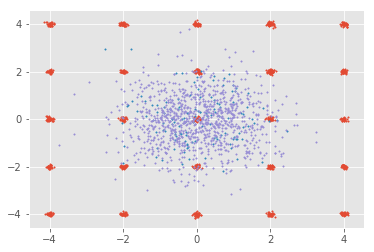

step 1000: KL: 1.994e+01, rec: -9.821e+00


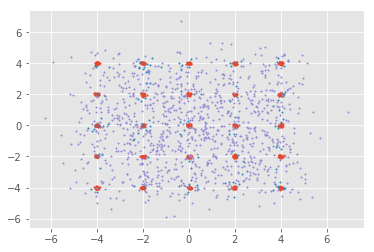

step 2000: KL: 2.063e+01, rec: -1.371e+01


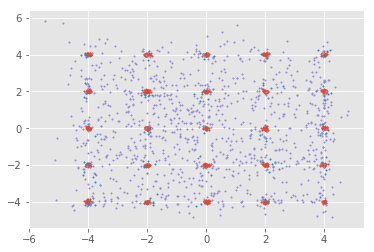

step 3000: KL: 2.043e+01, rec: -1.311e+01


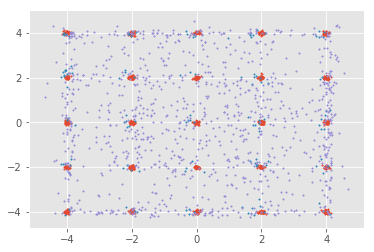

step 4000: KL: 2.105e+01, rec: -1.447e+01


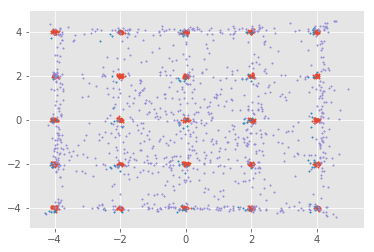

step 5000: KL: 2.089e+01, rec: -1.683e+01


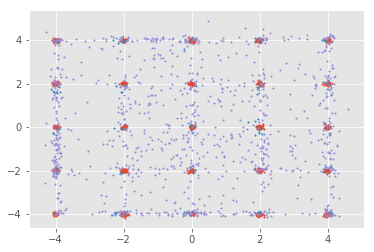

step 6000: KL: 2.123e+01, rec: -1.829e+01


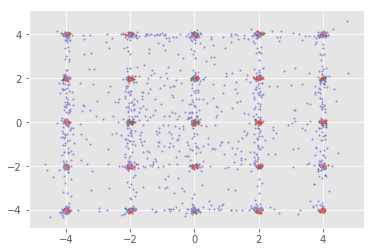

step 7000: KL: 2.093e+01, rec: -1.099e+01


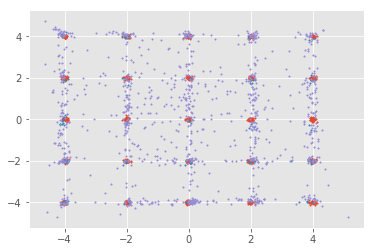

step 8000: KL: 2.050e+01, rec: -1.913e+01


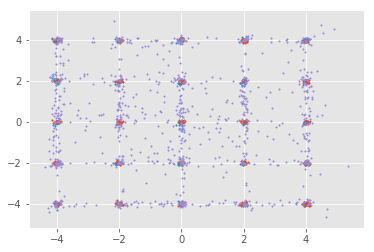

step 9000: KL: 2.076e+01, rec: -2.022e+01


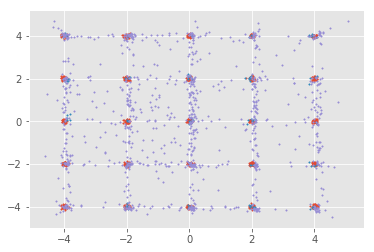

step 10000: KL: 2.071e+01, rec: -8.788e+00


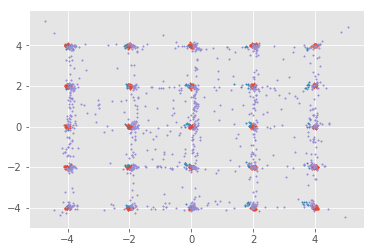

step 11000: KL: 2.081e+01, rec: -1.660e+01


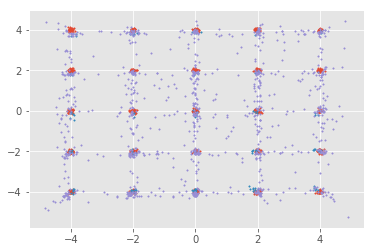

step 12000: KL: 2.109e+01, rec: -2.020e+01


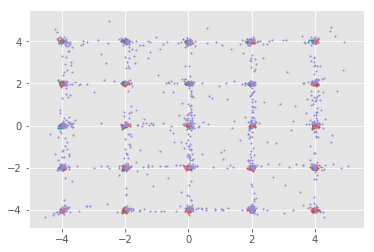

step 13000: KL: 2.085e+01, rec: -2.067e+01


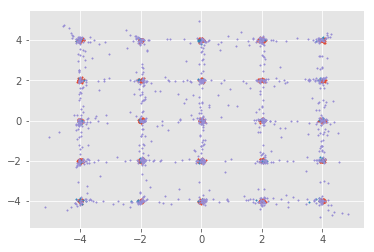

step 14000: KL: 2.090e+01, rec: -1.983e+01


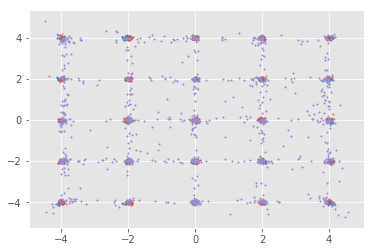

step 15000: KL: 2.102e+01, rec: -2.101e+01


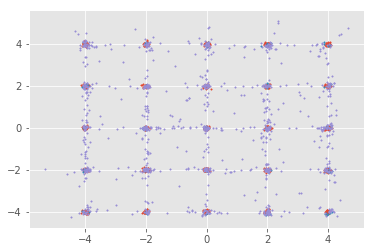

step 16000: KL: 2.061e+01, rec: -1.946e+01


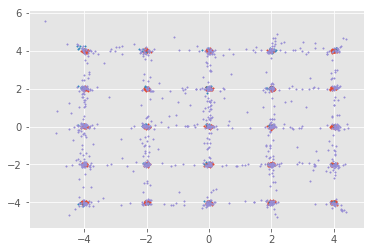

step 17000: KL: 2.092e+01, rec: -2.055e+01


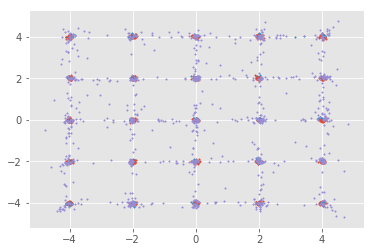

step 18000: KL: 2.049e+01, rec: -2.100e+01


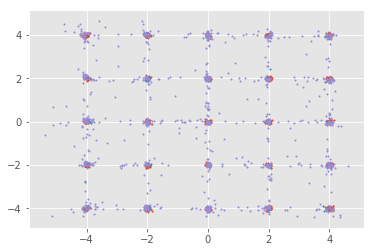

step 19000: KL: 2.111e+01, rec: -1.299e+01


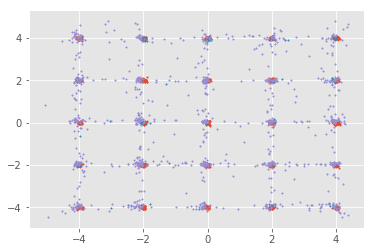

step 20000: KL: 2.071e+01, rec: -2.026e+01


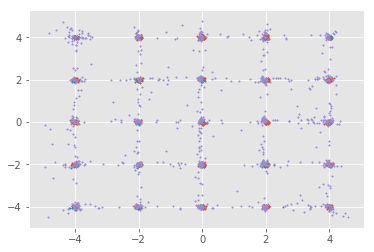

step 21000: KL: 1.949e+01, rec: -1.958e+01


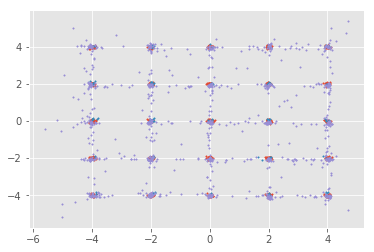

step 22000: KL: 1.962e+01, rec: -7.350e+00


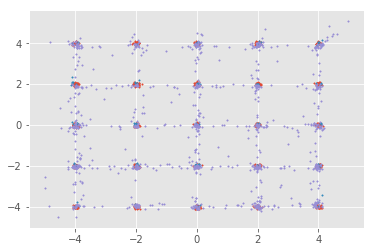

step 23000: KL: 2.078e+01, rec: -1.978e+01


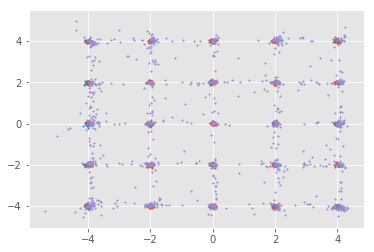

step 24000: KL: 1.994e+01, rec: -2.098e+01


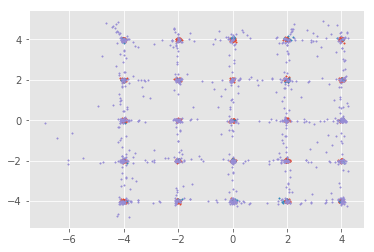

step 25000: KL: 2.025e+01, rec: -1.670e+01


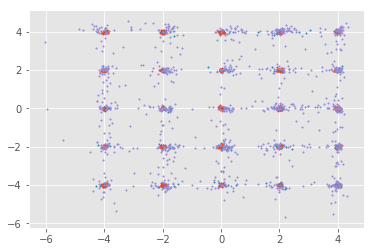

step 26000: KL: 1.981e+01, rec: -2.171e+01


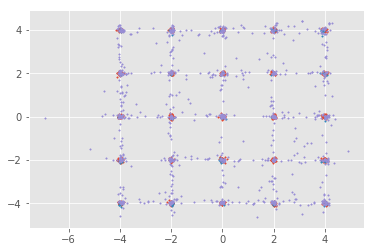

step 27000: KL: 1.974e+01, rec: -2.135e+01


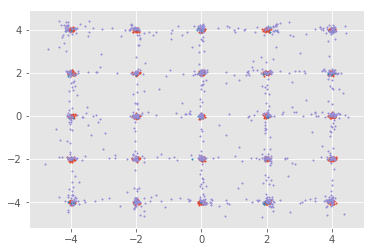

step 28000: KL: 2.016e+01, rec: -2.098e+01


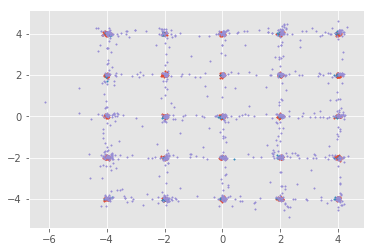

step 29000: KL: 2.007e+01, rec: -2.051e+01


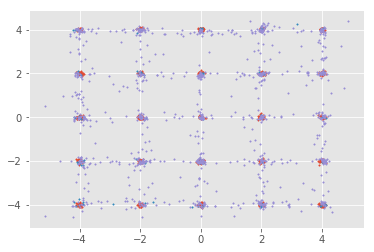

step 30000: KL: 2.077e+01, rec: -1.795e+01


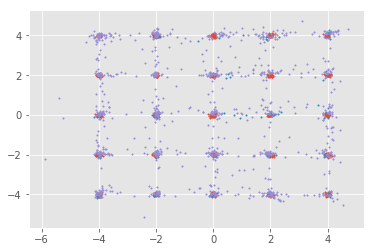

step 31000: KL: 1.987e+01, rec: -2.112e+01


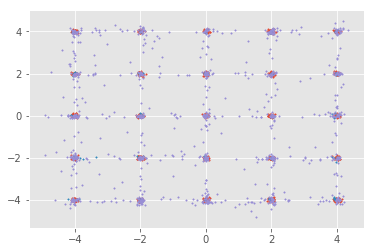

step 32000: KL: 1.963e+01, rec: -1.978e+01


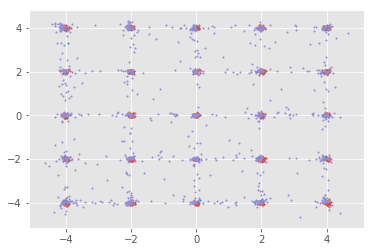

step 33000: KL: 2.039e+01, rec: -2.021e+01


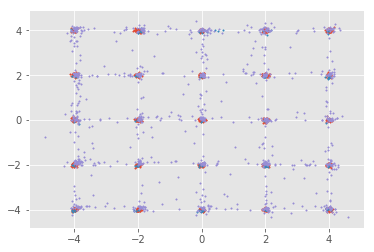

step 34000: KL: 1.951e+01, rec: -1.782e+01


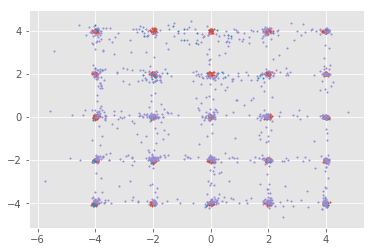

step 35000: KL: 1.960e+01, rec: -1.751e+01


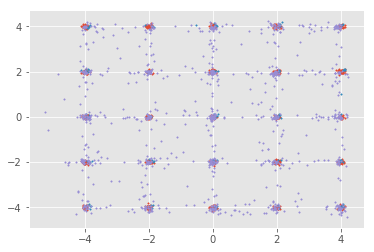

step 36000: KL: 1.941e+01, rec: -2.088e+01


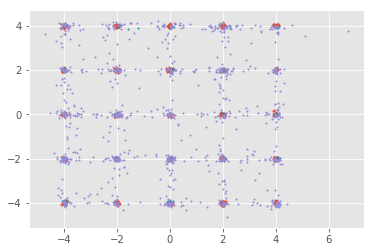

step 37000: KL: 1.953e+01, rec: -2.061e+01


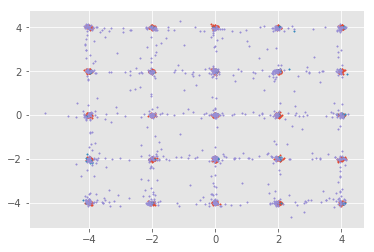

step 38000: KL: 1.924e+01, rec: -1.824e+01


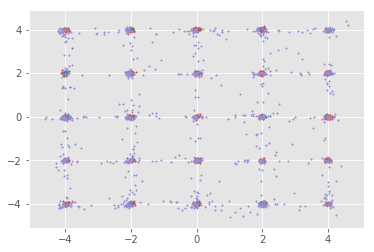

step 39000: KL: 1.991e+01, rec: -1.725e+01


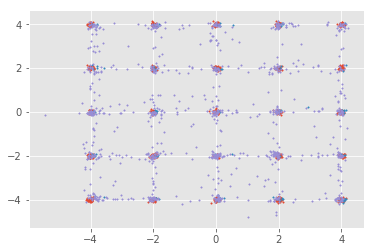

step 40000: KL: 2.022e+01, rec: -1.957e+01


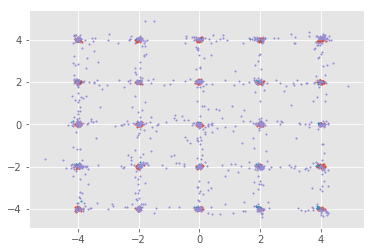

In [6]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    # Compute here the DKL part of the VAE loss
    
    # STARTING FILL
    loss_kl = torch.mean(torch.sum(torch.exp(enc_logvar), 1)+ torch.sum(enc_mu*enc_mu,1)- torch.sum(enc_logvar, 1))
    
    # Compute here the sample z, using Q12
    z = (torch.normal(torch.zeros(BATCHLEN, LATENT_N), 1.0)* torch.exp(0.5*enc_logvar)+ enc_mu)
    
    dec_mu, dec_logvar = decoder(z)
    
    loss_rec = torch.mean(2*torch.sum(dec_logvar,1)+ torch.sum(torch.exp(-dec_logvar)*(x-dec_mu)*(x-dec_mu),1)
    )
    # ENDING FILL
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.show()

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

> It will accelerate the training, however we are likely to see divergence occuring when missing the local minimum.

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

> When we increase the latent dimension the representation becomes more powerful. However if we exceed, divergence occurs. It seems that a model too powerful overfits and fails to fit the general patterns of the data.

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

>GANs are promising and according to the litterature and to this Homework, they are known to be powerful and generate pretty well when convergence is reached. However they are generally trickier to train, as we can see in this homework. It seems that they are quite longer to train as well and not robust to hyperparameter choices.

>VAEs on the contrary are quite easier to train and get working. They are relatively easy to implement and robust to hyperparameter choices. They are more explicit in the formulation of the inference network. But as the noice in our final image shows, the representation of the VAEs are less precise and accurate than GANs in the long shot.